# Introduction

## Table of Contents

In [195]:
# Import libralies
import pandas as pd
import numpy as np
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import datetime as dt
import matplotlib.pyplot as plt

# Gather

In [2]:
# Import csv file
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# Create folder if not exist
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Get url, save tsv file into the folder just created
url_list = ['https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv']

for url in url_list:
    response = requests.get(url)
    with open(os.path.join(folder_name , url.split('/')[-1]) , mode = 'wb') as file:
             file.write(response.content)

In [4]:
# Read tsv file
image_prediction = pd.read_csv('image_predictions/image-predictions.tsv' , sep = '\t')

### Additional Data via the Twitter API

# I used configparser for my API keys and secret.
# This code returns error if you do not input your API and secret info.

import configparser

config = configparser.ConfigParser()

config['consumer'] = {
    'key': 'YOUR CONSUMER KEY',
    'secret': 'YOUR CONSUMER SECRET'
}
config['access'] = {
    'token': 'YOUR ACCESS TOKEN',
    'secret': 'YOUR ACCESS SECRET',
}
with open('config.ini', 'w') as file:
    config.write(file)

# Read APi info from config.ini

consumer_key = config['consumer']['key']
consumer_secret = config['consumer']['secret']
access_token = config['access']['token']
access_secret = config['access']['secret']


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth , wait_on_rate_limit=True)

# Use timer to calculate how long this code takes to run
start = timer()

# Create a text file called tweet_json.txt
tweet_ids = twitter_archive.tweet_id.values
with open ('tweet_json.txt' , 'w') as outfile:
    for tweet_id in tweet_ids:
        try:
            # Get tweet informations
            tweet_info = api.get_status(tweet_id, tweet_mode='extended')
            #Write in the text file
            json.dump(tweet_info._json , outfile)
            # Put a indent for better readiness
            outfile.write('\n')
        
        # Error tweets
        except tweepy.TweepError as e:
            # Print tweet ID and error code description
            print ("Tweet ID:{}{}".format(str(tweet_id),e.reason))

# Timer calculation            
end = timer()
print(end - start , "seconds")

In [5]:
# Save extracted data
tweepy_data = pd.read_json('tweet_json.txt' , lines = True)

# Assess

## twitter_archive

In [6]:
twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [7]:
# Tweet id has wrong datatype
# Timestamp has wrong datatype
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [8]:
# There are some strange names
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
           ... 
Aiden         1
Willow        1
Storkson      1
Lucia         1
Noah          1
Name: name, Length: 957, dtype: int64

In [9]:
# Rating numerator has some outliers
twitter_archive.rating_numerator.value_counts() 

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [10]:
# This tweet numerators look 75, but actual values are 9.75.
twitter_archive.query('rating_numerator == 75').text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)

,0,1
340,9.75,10
695,9.75,10


In [11]:
# Some denominators are not 10
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

## image_prediction

In [12]:
image_prediction.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [13]:
# Some column headers are hard to understand
# Tweet_id datatype needs to be object
# Dog breed names in  are inconsistent 
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## tweepy_data

In [14]:
pd.set_option('display.max_columns', None)
tweepy_data.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,NaN,None,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN,None,NaN,False,7703,36183,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN,NaN


In [15]:
# id column needs to be datatype object 
tweepy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   created_at                     2331 non-null   datetime64[ns, UTC]
 1   id                             2331 non-null   int64              
 2   id_str                         2331 non-null   int64              
 3   full_text                      2331 non-null   object             
 4   truncated                      2331 non-null   bool               
 5   display_text_range             2331 non-null   object             
 6   entities                       2331 non-null   object             
 7   extended_entities              2059 non-null   object             
 8   source                         2331 non-null   object             
 9   in_reply_to_status_id          77 non-null     float64            
 10  in_reply_to_status_id_st

## Quality Issues

**twitter_archive** 

1- `tweet_id` datatype needs to be object (str)\
2- `timestamp` column is object, not datetime\
3- `timestamp` column contains +0000 which looks unnecessary\
4- Retweet or reply tweets are unnecessary (only original dog ratings)\
5- `name` column has some strange names (a, an etc.)\
6- `rating_numerator` of id 786709082849828864 is decimal\
7- `doggo`, `floofer`, `pupper`, `puppo` columns (dog_stage column) have missing values

**image_prediction**

1- Some column headers are hard to understand(`img_num`, `p1`, `p1_conf`, `p1_dog`, etc.)\
2- `tweet_id` datatype needs to be object\
3- Dog breed names in `p1`, `p2`, `p3` columns are inconsistent (lowercase, uppercase)

**tweepy_data**

1- Drop unneccesary columns (keep `id` , `retweet_count`, `favorite_count` columns)\
2- `id` column datatype needs to be object\
3- Change id column name to `tweet_id`

## Tidiness

#### twitter_archive

1- `doggo`, `floofer`, `pupper`, `puppo` columns instead of a single column dog_stage\
2- `rating_numerator`, `rating_denominator` columns should be one column(rating)

**After taking care of dirty and untidy data, all tables need to be merged.\
According to the rule of tidy data:**\
1: Each variables forms a column\
2: Each observation forms a row\
3: Each type of observational unit forms a table\
\
And `twitter_archive`, `image_prediction`, `tweepy_data` are all about WeRateDog tweet information, hence it breaks the 3rd rule. I should merge all of them. 

# Data cleaning

Data cleaning has three steps.

**Define**: convert our assessments into defined cleaning tasks. These definitions also serve as an instruction list so others (or yourself in the future) can look at your work and reproduce it.

**Code**: convert those definitions to code and run that code.

**Test**: test your dataset, visually or with code, to make sure your cleaning operations worked.

In [16]:
# make a copy
twitter_archive_clean = twitter_archive.copy()
image_prediction_clean = image_prediction.copy()
tweepy_data_clean = tweepy_data.copy()

## twitter_archive_clean

### 1- `tweet_id` datatype needs to be object (str)\
### 2- `timestamp` column is object, not datetime\
### 3- `timestamp` column contains +0000 which looks unnecessary

#### Define

Change datatype from integer to string
Change datatype from string to datetime
Slice data

#### Code

In [17]:
# id to string
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)
# Remove +0000
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.str[:-6]
# Change datatype of timestamp column to datetime
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [18]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [19]:
twitter_archive_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


### 4- retweet or reply tweets are unnecessary (only original dog ratings)

#### Define

Drop retweets and replies, then drop unnecessary columns

#### Code

In [20]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2356 non-null   datetime64[ns]
 4   source                      2356 non-null   object        
 5   text                        2356 non-null   object        
 6   retweeted_status_id         181 non-null    float64       
 7   retweeted_status_user_id    181 non-null    float64       
 8   retweeted_status_timestamp  181 non-null    object        
 9   expanded_urls               2297 non-null   object        
 10  rating_numerator            2356 non-null   int64         
 11  rating_denominator          2356 non-null   int64       

In [21]:
# Drop 78 replies
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

In [22]:
# Drop 181 retweets
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

In [23]:
# 2356 - 78 - 181 = 2097
len(twitter_archive_clean)

2097

In [24]:
# Drop unnecessary columns
coldrop = twitter_archive_clean.iloc[:,np.r_[1,2,6:9]].columns
twitter_archive_clean.drop(coldrop, axis = 1,inplace = True)

#### Test

In [25]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   object        
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   expanded_urls       2094 non-null   object        
 5   rating_numerator    2097 non-null   int64         
 6   rating_denominator  2097 non-null   int64         
 7   name                2097 non-null   object        
 8   doggo               2097 non-null   object        
 9   floofer             2097 non-null   object        
 10  pupper              2097 non-null   object        
 11  puppo               2097 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 213.0+ KB


### 5- name column has some strange names (a, an etc.)

#### Define

All dog names are capitalized, but there are some tweets has non_dog names (a, an, etc.) and they are all lowercase.
Make a filter to figure out all lowercase names and drop those names.

#### Code

In [26]:
# Filter out all lowercase names
name_filter = twitter_archive_clean.name.str.islower()
column_name = 'name'
# Drop lowercase names
twitter_archive_clean.loc[name_filter, column_name] = np.nan

#### Test

In [27]:
twitter_archive_clean.name.value_counts()

None       603
Lucy        11
Charlie     11
Oliver      10
Cooper      10
          ... 
Socks        1
Lugan        1
Billl        1
Spencer      1
Noah         1
Name: name, Length: 930, dtype: int64

### 6- rating_numerator of id 786709082849828864 is decimal

#### Define

Extract correct rating score from `text` column by using regular expressions,\
Replace it to existing rating columns

#### Code

In [28]:
# Get correct ratings
correct_rating = twitter_archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
twitter_archive_clean['rating_numerator'] = correct_rating
# Some numerators are float
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype(float)

#### Test

In [29]:
twitter_archive_clean.rating_numerator.sample(5)

827     12.0
1461     5.0
2109     5.0
572     10.0
129     12.0
Name: rating_numerator, dtype: float64

### 7- `doggo`, `floofer`, `pupper`, `puppo` columns (dog_stage column) have missing values

#### Define

Extract dog stage from text column\

#### Code

In [30]:
# doggo
twitter_archive_clean['doggo'] = twitter_archive_clean.text.str.extract('([Dd]oggo)')

In [31]:
# floofer
twitter_archive_clean['floofer'] = twitter_archive_clean.text.str.extract('([Ff]loofer)')

In [32]:
# pupper
twitter_archive_clean['pupper'] = twitter_archive_clean.text.str.extract('([Pp]upper)')

In [33]:
# puppo
twitter_archive_clean['puppo'] = twitter_archive_clean.text.str.extract('([Pp]uppo)')

#### Test

In [34]:
# I was able to get more information from text (83 → 90 (83 + 7) )
twitter_archive_clean.doggo.value_counts()

doggo    83
Doggo     7
Name: doggo, dtype: int64

In [35]:
# Although there are tweet text don't have dog stage information. I have no way to extract in this case.
print(twitter_archive_clean.at[0,'text'])

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU


## Image_prediction

### 1- some column headers are hard to understand(img_num, p1, p1_conf, p1_dog, etc.)

#### Define

Create new columns `dog_breed` , `confidence` , `dog_or_not` to store all p1, p2, p3 datas\
Change `img_num` name to `image_counts`\
Drop unnecessary columns

#### Code

In [36]:
# Create dog breed column.
# This column uses information from p1, p2, p3 and show dog name.
# If there is no dog info available on p1, then show p2 info. If not, then show p3 info.

def dog_breed(row):
    if row.p1_dog:
        return row.p1
    elif row.p2_dog:
        return row.p2
    elif row.p3_dog:
        return row.p3
    else:
        return np.nan
    
image_prediction_clean['dog_breed'] = image_prediction_clean.apply(lambda row: dog_breed(row),axis=1)

In [37]:
# Create confidence column
# This column does same thing of dog breed column, only difference is this column show confidence level of predictions

def dog_prediction(row):
    if row.p1_dog:
        return row.p1_conf
    elif row.p2_dog:
        return row.p2_conf
    elif row.p3_dog:
        return row.p3_conf
    else:
        return np.nan
    
image_prediction_clean['confidence'] = image_prediction_clean.apply(lambda row: dog_prediction(row),axis=1)

In [38]:
# Create dog or not column
# This cell only returns True or False.
# If there are dog information available from p1, p2, p3, then show True, show False if there are no dog information available.

dog_or_not = []
for i in range(2075):
    if image_prediction_clean['p1_dog'][i]:
        dog_or_not.append("True")
        
    elif image_prediction_clean['p2_dog'][i]:
        dog_or_not.append("True")
        
    elif image_prediction_clean['p3_dog'][i]:
        dog_or_not.append("True")
        
    else:
        dog_or_not.append("False")
        
image_prediction_clean['dog_or_not'] = dog_or_not

In [39]:
# Change column name for better readiness
image_prediction_clean = image_prediction_clean.rename(columns={'img_num':'image_counts'})

In [40]:
# Drop unnecessary columns

coldrop = image_prediction_clean.iloc[:,np.r_[3:12]].columns
image_prediction_clean.drop(coldrop, axis = 1,inplace = True)

#### Test

In [41]:
image_prediction_clean.head()

,tweet_id,jpg_url,image_counts,dog_breed,confidence,dog_or_not
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True


### 2- tweet_id datatype needs to be object 

#### Define

Change datatype to string

#### Code

In [42]:
image_prediction_clean.tweet_id = image_prediction_clean.tweet_id.astype(str)

#### Test

In [43]:
# tweet_id is now object
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tweet_id      2075 non-null   object 
 1   jpg_url       2075 non-null   object 
 2   image_counts  2075 non-null   int64  
 3   dog_breed     1751 non-null   object 
 4   confidence    1751 non-null   float64
 5   dog_or_not    2075 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 97.4+ KB


### 3- dog breed names are inconsistent (lowercase, uppercase)

#### Define

Change dog names into lowercase

#### Code

In [44]:
image_prediction_clean.dog_breed = image_prediction_clean.dog_breed.str.lower()

#### Test

In [45]:
# dog_breed names are now lowercase
image_prediction_clean.head(1)

,tweet_id,jpg_url,image_counts,dog_breed,confidence,dog_or_not
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True


## tweepy_data

### 1- unneccesary columns (keep id , retweet_count, favorite_count columns)


#### Define

Reassign columns

#### Code

In [46]:
tweepy_data_clean = tweepy_data_clean[['id','retweet_count','favorite_count']]

#### Test

In [47]:
tweepy_data_clean.head(1)

,id,retweet_count,favorite_count
0,892420643555336193,7703,36183


### 2- id column datatype needs to be object

#### Define

Change datatype to string

#### Code

In [48]:
tweepy_data_clean.id = tweepy_data_clean.id.astype(str)

#### Test

In [49]:
# id  column is now object
tweepy_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2331 non-null   object
 1   retweet_count   2331 non-null   int64 
 2   favorite_count  2331 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.8+ KB


## 3- change id column name to tweet_id

#### Define

Rename `id` column

#### Code

In [50]:
tweepy_data_clean = tweepy_data_clean.rename(columns={'id':'tweet_id'})

#### Test

In [51]:
# column name is now same as the other two database
tweepy_data_clean.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7703,36183


# Tidiness

## Twitter_archive

### 1- doggo, floofer, pupper, puppo columns instead of a single column dog_stage

#### Define

Extract dog stage info from text one more time
Create dog_stage column, extract informations from `doggo`, `floofer`, `pupper`, `puppo` column.
Some tweet texts mention dog stages with uppercase letter, so I extract both uppercase and lowercase.
Also, some tweet text contains two dog stages (ie:doggo and pupper) so make sure to catch them too

#### Code

In [52]:
# Extract basic 4 dog stages from text column

twitter_archive_clean['doggo'] = twitter_archive_clean.text.str.extract('([Dd]oggo)', expand = True)
twitter_archive_clean['floofer'] = twitter_archive_clean.text.str.extract('([Ff]loofer)', expand = True)
twitter_archive_clean['pupper'] = twitter_archive_clean.text.str.extract('([Pp]upper)', expand = True)
twitter_archive_clean['puppo'] = twitter_archive_clean.text.str.extract('([Pp]uppo)', expand = True)

In [53]:
# Lowercase all of informations for better readiness

twitter_archive_clean['doggo'] = twitter_archive_clean['doggo'].str.lower()
twitter_archive_clean['floofer'] = twitter_archive_clean['floofer'].str.lower()
twitter_archive_clean['pupper'] = twitter_archive_clean['pupper'].str.lower()
twitter_archive_clean['puppo'] = twitter_archive_clean['puppo'].str.lower()

In [54]:
# Rename None and NaN to ''  for dog stage column can catch accurate information

twitter_archive_clean.doggo.replace('None', '', inplace=True)
twitter_archive_clean.doggo.replace(np.NaN, '', inplace=True)
twitter_archive_clean.floofer.replace('None', '', inplace=True)
twitter_archive_clean.floofer.replace(np.NaN, '', inplace=True)
twitter_archive_clean.pupper.replace('None', '', inplace=True)
twitter_archive_clean.pupper.replace(np.NaN, '', inplace=True)
twitter_archive_clean.puppo.replace('None', '', inplace=True)
twitter_archive_clean.puppo.replace(np.NaN, '', inplace=True)

In [55]:
# Create dog stage column by adding all 4 dog stage informations.
# Sometimes tweets have 2 dog stage informations, 

twitter_archive_clean['dog_stages'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggopupper', 'dog_stages'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggopuppo', 'dog_stages'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stages == 'doggofloofer', 'dog_stages'] = 'doggo, floofer'

In [56]:
# Put NaN for tweets don't have dog_stage info
twitter_archive_clean.dog_stages.replace('', np.NaN, inplace=True)

In [57]:
# Drop unnecessary columns
twitter_archive_clean = twitter_archive_clean.drop(['doggo', 'pupper', 'floofer', 'puppo' ], axis = 1)

#### Test

In [58]:
# All dog_stages are extracted properly
twitter_archive_clean.dog_stages.value_counts()

pupper            243
doggo              78
puppo              28
floofer             9
doggo, pupper       9
doggo, puppo        2
doggo, floofer      1
Name: dog_stages, dtype: int64

In [59]:
# All tweets don't have dog_stage info have NaN
twitter_archive_clean.dog_stages

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
2351    NaN
2352    NaN
2353    NaN
2354    NaN
2355    NaN
Name: dog_stages, Length: 2097, dtype: object

In [60]:
# Columns look tidy
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,NaN


### 2- rating_numerator, rating_denominator columns should be one column(rating)

#### Define

Devide `rating_numerator` by `rating_denominator` to compute rating
Drop unnecessary columns

#### Code

In [61]:
# Compute numerator / denominator ratio to see tweets score.
twitter_archive_clean['rating_ratio'] = twitter_archive_clean.rating_numerator / twitter_archive_clean.rating_denominator

In [62]:
# Drop unnecessary columns
twitter_archive_clean = twitter_archive_clean.drop(['rating_numerator'] , axis = 1)
twitter_archive_clean = twitter_archive_clean.drop(['rating_denominator'] , axis = 1)

#### Test

In [63]:
twitter_archive_clean.head(1)

,tweet_id,timestamp,source,text,expanded_urls,name,dog_stages,rating_ratio
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,Phineas,NaN,1.3


In [64]:
# There are some outliers (177.60 , 0.00), but I will keep it for now
twitter_archive_clean.rating_ratio.value_counts()

1.200000      490
1.000000      438
1.100000      418
1.300000      287
0.900000      153
0.800000       98
0.700000       51
1.400000       38
0.500000       34
0.600000       32
0.300000       19
0.400000       15
0.200000       10
0.100000        4
1.350000        1
3.428571        1
1.127000        1
0.636364        1
1.126000        1
177.600000      1
42.000000       1
0.975000        1
0.000000        1
0.818182        1
Name: rating_ratio, dtype: int64

### Merge three databases

#### Define

**According to the rule of tidy data:**
1: Each variables forms a column\
2: Each observation forms a row\
3: Each type of observational unit forms a table\

And twitter_archive, image_prediction, tweepy_data are all about WeRateDog tweet information, hence it breaks the 3rd rule. I should merge all of them.

#### Code

In [65]:
# Merge databases
twitter_archive_master = twitter_archive_clean.merge(tweepy_data_clean, on = 'tweet_id') 
twitter_archive_master = twitter_archive_master.merge(image_prediction_clean,    on = 'tweet_id', how = 'left') 
#Drop unnecessary columns
twitter_archive_master.drop(['source', 'text', 'expanded_urls'],    inplace = True, axis = 1)

In [66]:
# reassign column for better readiness
twitter_archive_master = twitter_archive_master[['tweet_id', 'timestamp', 'retweet_count', 'favorite_count', 'name', 'dog_stages',
                                                'rating_ratio', 'dog_breed', 'confidence', 'dog_or_not', 'image_counts', 'jpg_url']]

#### Test

In [67]:
twitter_archive_master.head()

,tweet_id,timestamp,retweet_count,favorite_count,name,dog_stages,rating_ratio,dog_breed,confidence,dog_or_not,image_counts,jpg_url
0,892420643555336193,2017-08-01 16:23:56,7703,36183,Phineas,NaN,1.3,NaN,NaN,False,1.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,2017-08-01 00:17:27,5696,31217,Tilly,NaN,1.3,chihuahua,0.323581,True,1.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03,3776,23501,Archie,NaN,1.2,chihuahua,0.716012,True,1.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51,7870,39489,Darla,NaN,1.3,labrador_retriever,0.168086,True,1.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24,8478,37709,Franklin,NaN,1.2,basset,0.555712,True,2.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg


In [68]:
# Save as a new file
twitter_archive_master.to_csv('tweet_archive_master.csv', index=False)

# Analysis

## Q1: Is there certain dog breed have higher retweets and likes?
## Q2: Which stage of dogs are favored by the account?
## Q3: Do users retweet and like if tweets have more images?

#### Q1: Define

Groupby dog breed, apply retwwet_count + favorite_count, then sort values

#### Code

In [206]:
dog_score = twitter_archive_master.groupby(['dog_breed']).apply(lambda d: (d.retweet_count + d.favorite_count).mean())
dog_score.sort_values(ascending=False).head(10)

dog_breed
bedlington_terrier         30297.000000
saluki                     26713.000000
french_bulldog             23571.366667
afghan_hound               20991.333333
bouvier_des_flandres       20381.000000
flat-coated_retriever      19500.250000
black-and-tan_coonhound    19285.000000
irish_water_spaniel        18935.666667
whippet                    17998.272727
english_springer           17760.500000
dtype: float64

#### Test

In [126]:
dog_score.rank(ascending=False , na_option='bottom').sort_values()

dog_breed
bedlington_terrier        1.0
saluki                    2.0
french_bulldog            3.0
afghan_hound              4.0
bouvier_des_flandres      5.0
                        ...  
tibetan_terrier         109.0
irish_wolfhound         110.0
japanese_spaniel        111.0
groenendael             112.0
brabancon_griffon       113.0
Length: 113, dtype: float64

## Bedlington terrier, Saluki, French bulldog are user's favorite

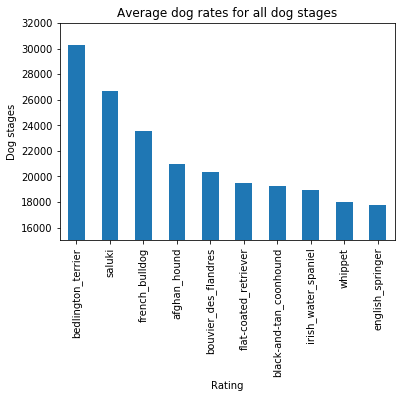

In [208]:
dog_score.sort_values(ascending=False).head(10).plot(kind = 'bar')
plt.ylim(15000, 32000)
plt.title('Average dog rates for all dog stages')
plt.xlabel('R')
plt.ylabel('Dog stages');

#### Q2: Define

Drop outliers, groupby dog_stage, find a mean of rating_ratio, then make a ranking

In [157]:
# Drop outliers for fairness
twitter_archive_master.rating_ratio.value_counts()

1.200000      488
1.000000      437
1.100000      418
1.300000      283
0.900000      153
0.800000       98
0.700000       51
1.400000       38
0.500000       34
0.600000       32
0.300000       19
0.400000       15
0.200000       10
0.100000        4
1.350000        1
3.428571        1
1.127000        1
0.636364        1
1.126000        1
177.600000      1
42.000000       1
0.975000        1
0.000000        1
0.818182        1
Name: rating_ratio, dtype: int64

In [147]:
twitter_archive_master.query('rating_ratio >= 1.5 or  rating_ratio == 0.000000')

In [148]:
clear_rating = twitter_archive_master.drop([243, 399, 764, 1814])

In [159]:
dog_rate = clear_rating.groupby(['dog_stages']).rating_ratio.mean()
dog_rate.sort_values( ascending=False)

dog_stages
doggo, puppo      1.300000
puppo             1.207407
floofer           1.188889
doggo             1.177922
doggo, pupper     1.111111
doggo, floofer    1.100000
pupper            1.066885
Name: rating_ratio, dtype: float64

#### Test

In [160]:
dog_rate.rank(ascending=False , na_option='bottom').sort_values()

dog_stages
doggo, puppo      1.0
puppo             2.0
floofer           3.0
doggo             4.0
doggo, pupper     5.0
doggo, floofer    6.0
pupper            7.0
Name: rating_ratio, dtype: float64

## WeRateDogs favors Doggo&Puppo, Puppo, Floofer dog stage 

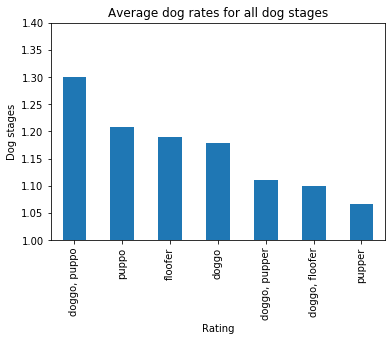

In [205]:
dog_rate.sort_values( ascending=False).plot(kind = 'bar')
plt.ylim(1.0, 1.4)
plt.title('Average dog rates for all dog stages')
plt.xlabel('Rating')
plt.ylabel('Dog stages');

#### Q3: Define

Groupby image_counts, apply retweet_counts + favorite_count

#### Code

In [190]:
twitter_archive_master.groupby(['image_counts']).apply(lambda d: (d.retweet_count + d.favorite_count).mean())

image_counts
1.0     9925.104982
2.0    15583.645503
3.0    15854.661017
4.0    19282.866667
dtype: float64

## Users tend to retweet or like if tweets have more pictures.

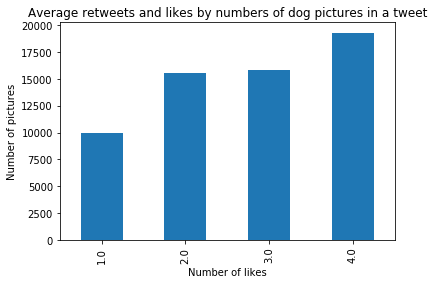

In [197]:
twitter_archive_master.groupby(['image_counts']).apply(lambda d: (d.retweet_count + d.favorite_count).mean()).plot(kind = 'bar')
plt.title('Average retweets and likes by numbers of dog pictures in a tweet')
plt.xlabel('Number of likes')
plt.ylabel('Number of pictures');